# Analysis description

The following scripts parametrise resting state EEG data.

 - `01_load_data.py` Load data into `xarray` array
 - `02_compute_params.py` Compute spectrum, estimate parameters and save into intermediate file.
 
 There is alternative script `02_compute_spectrum.py` that computes the spectrum only.

To run these scripts from the notebook, the line magic `%run` is used.
Putting `%%script false --no-raise-error` at the top of the cell are preventing this cell from running (as the values are already computes).


In [ ]:
%%script false --no-raise-error
%cd '/Users/daniel/PhD/Projects/ephys-poirot-analysis/studies/MEG_ASSR_RS'
!python '01_load_data.py'
!python '02_compute_params.py'

## `Specparam` algorithm use

The `specparam` algorithm (developmental version, git commit …) was used to parametrise power spectra. We defined parameters in the following way: peak width limits: [2 8]; max number of peaks: 6; minimum peak height: 0.5; peak threshold: 2; and aperiodic mode: ‘fixed’. Power spectra were parametrised across the frequency range 2 to 48 Hz. 



# Visualise computed spectrum

In [1]:
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt

<xarray.DataArray (regions: 14, freqs: 1201)>
array([[8.31883360e-25, 3.18676984e-25, 5.89084945e-25, ...,
        3.02064142e-36, 3.32312352e-36, 1.93999189e-36],
       [5.02838086e-25, 1.83144861e-25, 8.20576866e-25, ...,
        3.02452050e-36, 3.58022455e-36, 2.22795288e-36],
       [3.22921000e-24, 1.20640400e-24, 2.59025109e-24, ...,
        9.19044154e-36, 1.06787582e-35, 6.13015470e-36],
       ...,
       [4.28880897e-25, 1.59208956e-25, 3.34267139e-25, ...,
        1.10817307e-36, 1.24750876e-36, 6.73555039e-37],
       [1.26374111e-24, 4.34774285e-25, 3.34066840e-24, ...,
        1.21854667e-35, 1.31096513e-35, 7.31559154e-36],
       [2.56037387e-24, 9.15355255e-25, 4.16748258e-24, ...,
        8.89854076e-36, 1.05245068e-35, 6.03693384e-36]])
Coordinates:
  * freqs    (freqs) float64 0.0 0.25 0.5 0.75 1.0 ... 299.2 299.5 299.8 300.0
  * regions  (regions) object 'LC' 'LF' 'LL' 'LO' 'LP' ... 'RO' 'RP' 'RPF' 'RT'

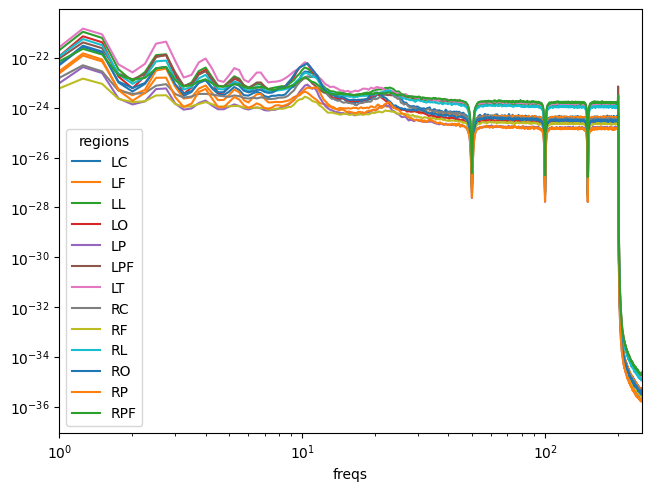

In [31]:
DATA_FOLDER = "/Volumes/ExtremePro/Analyses/ASP0"

da = xr.open_dataarray(f"{DATA_FOLDER}/interim/power/S010_MEG_ASSR_power.nc")
da.close()
fig, ax = plt.subplots(layout='constrained')

y = (
    da
    .mean("trial")
    .mean("iter_number")
    .mean("session")
    .mean("sub")
    .groupby("regions")
    .mean("labels")
)
display(y)
(y
 .isel(regions=slice(0, 13))
 .plot.line(
    x="freqs", xlim=[1, 250], yscale='log', xscale='log')
 ) # type: ignore
# fig.legend(loc='outside right upper')
plt.show()


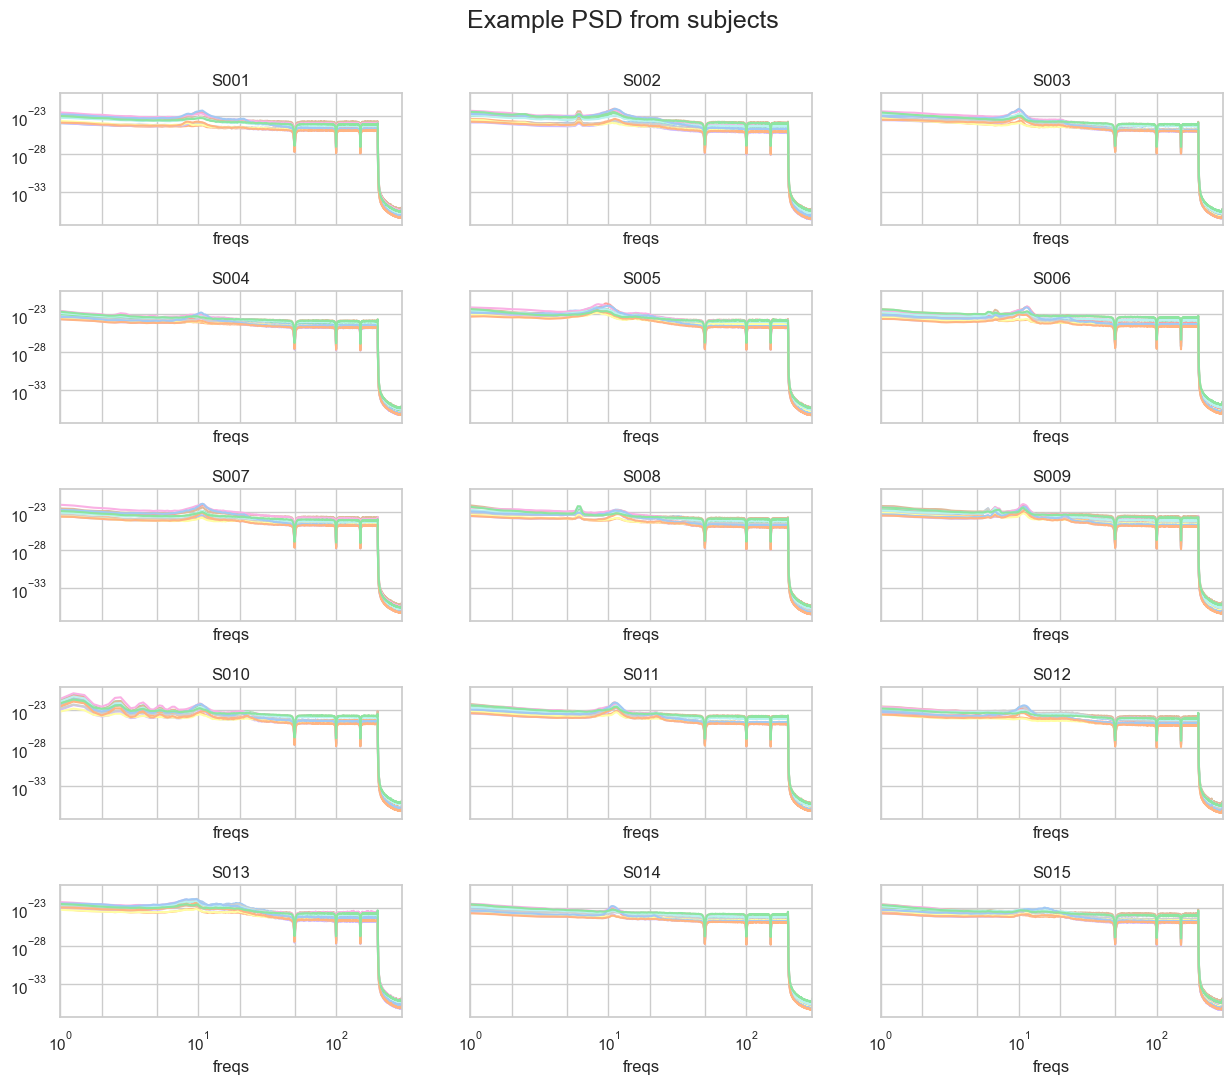

In [45]:
import seaborn as sns
import matplotlib

sns.set_theme(style="whitegrid", palette="pastel")

DATA_FOLDER = "/Volumes/ExtremePro/Analyses/ASP0"
SUBS = ['S001', 'S002', 'S003', 'S004', 'S005', 'S006', 'S007', 
        'S008', 'S009', 'S010', 'S011', 'S012', 'S013', 'S014', 'S015']

SUB = 'S001'
def plot_subjects(DATA_FOLDER, SUB,ax):
    da = xr.open_dataarray(f"{DATA_FOLDER}/interim/power/{SUB}_MEG_ASSR_power.nc")
    da.close()
    (
        da
        .mean("trial")
        .mean("iter_number")
        .mean("session")
        .mean("sub")
        .groupby("regions")
        .mean("labels")
        .isel(regions=slice(0, 13))
        .plot.line(
            x="freqs",  xlim=[1, 300],  yscale='log', xscale='log', ax=ax)
        ) # type: ignore


fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(15, 12), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Example PSD from subjects", fontsize=18, y=0.95)
for SUB, ax in zip(SUBS, axs.ravel()):
#for SUB in SUBS:
    plot_subjects(DATA_FOLDER, SUB,ax)
    ax.set_title(SUB)
    ax.get_legend().remove()
    ax.set_xticks([1,2, 5, 10, 20, 50, 100])
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    #plt.title(SUB)
plt.show()
fig.savefig("overview_psds", dpi=300, bbox_inches='tight')


# Analysis of the `specparam` parameters

- [ ] First step will be to filter data to remove information about CF (we don't need it now)

In [27]:
import xarray as xr
import pandas as pd
import numpy as np
import tqdm as tqdm
from fooof import  FOOOFGroup

from poirot.spectrum import  specparam_attributes, my_compute_spectrum

DATA_FOLDER = "/Volumes/ExtremePro/Analyses/ASP0"

def process_spectrum(ds, stacked_cols, fg, freq_range):
    return (
        xr.apply_ufunc(
            my_compute_spectrum, ds, 
            vectorize=True,
            input_core_dims=[['time']],
            output_core_dims=[['freqs']],
            kwargs = {"fs" :fs, "nperseg":4*fs})
        .assign_coords(freqs = lambda x: np.linspace(0,fs/2, len(x.freqs)))
        .mean("trial")
        .mean("iter_number")
        .pipe(
            specparam_attributes,
            stacked_cols=stacked_cols,
            fg=fg,
            freq_range=freq_range,
        )
    )

SUBS = ['S001']

sessions = ["Session1", "Session2"]

fs = 600

fg = FOOOFGroup(
    peak_width_limits=[2, 8],
    min_peak_height=0.1,
    max_n_peaks=12,
)

freq_range = [2, 40]

stacked_cols = ['labels','sub','session']

for subject in SUBS:
        ds = xr.open_dataarray(f"{DATA_FOLDER }/interim/timeseries/{subject}_MEG_ASSR_times.nc")
        ds.close()
        df = (
        process_spectrum(ds, stacked_cols, fg, freq_range)
        .drop(['CF', 'PW', "BW"], axis=1)
        .drop_duplicates()
        )
        display(df)

Running FOOOFGroup: 100%|██████████| 136/136 [00:01<00:00, 112.48it/s]


,labels,sub,session,regions,offset,exponent,error,r_squared
0,bankssts L,S001,Session1,LT,-23.379191,0.851898,0.034009,0.985167
7,bankssts L,S001,Session2,LT,-23.243897,0.897257,0.036616,0.984142
15,bankssts R,S001,Session1,RT,-22.697404,1.024691,0.056335,0.975966
18,bankssts R,S001,Session2,RT,-23.173078,0.894421,0.045428,0.977465
21,caudalanteriorcingulate L,S001,Session1,LL,-23.415019,0.402003,0.032840,0.958955
...,...,...,...,...,...,...,...,...
550,temporalpole R,S001,Session2,RT,-21.630059,0.863917,0.041623,0.977425
555,transversetemporal L,S001,Session1,LT,-22.886564,0.630857,0.035158,0.971156
559,transversetemporal L,S001,Session2,LT,-22.598482,0.785864,0.041038,0.980689
565,transversetemporal R,S001,Session1,RT,-22.015955,0.859427,0.042299,0.979014


In [16]:

df = pd.read_hdf('MEG_ASSR_specparams.h5', key='specparam')
df.head()

df_filtered = (
    df
    .drop(['CF', 'PW', "BW"], axis=1)
    .drop_duplicates()
)
df.to_csv("specparms.csv")
df.head()

,labels,sub,session,regions,CF,PW,BW,offset,exponent,error,r_squared
0,bankssts L,S001,Session1,LT,8.056609,0.365005,2.000000,-23.362579,0.876533,0.033833,0.986118
1,bankssts L,S001,Session1,LT,10.653590,0.550840,2.000000,-23.362579,0.876533,0.033833,0.986118
2,bankssts L,S001,Session1,LT,13.122014,0.304396,2.000000,-23.362579,0.876533,0.033833,0.986118
3,bankssts L,S001,Session1,LT,16.038525,0.114416,2.014060,-23.362579,0.876533,0.033833,0.986118
4,bankssts L,S001,Session1,LT,21.162669,0.118779,5.400463,-23.362579,0.876533,0.033833,0.986118


In [ ]:
df

# Load example data and plot it on Desikan-Killyany atlas

## Specific parcelation

The parcelation that was use is Desikan-Killiany atlas (Destrieux et al., 2010) with 68 regions. The atlas was obtained from `nilearn` package (Abraham et al., 2014). 

```{r} 
[python-ggseg/ggseg.ipynb at main · danieltomasz/python-ggseg · GitHub](https://github.com/danieltomasz/python-ggseg/blob/main/doc/ggseg.ipynb)